## INVESTIGATE THE DATASET

In [20]:
import pandas as pd
import src.cleaning_functions as fn

First, let's import the clean dataset:

In [10]:
data = pd.read_csv('./OUTPUT/data_sharks_clean.csv')

To begin with, it is a good idea to take a look at the raw numbers:<br> **How many attacks could I classify to have happened during the night and during the day?**

Day      2568
Night     318
Name: night_day, dtype: int64


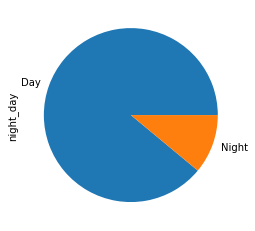

In [12]:
print(data.night_day.value_counts())
data.night_day.value_counts().plot.pie()

Not surprisingly, most of the attacks have happened during the day.There is usually more people in the water during the day than during the night. <br> This same pattern shows up when looking at the total number of fatal accidents during the day and night:

-Day counts:
 N    2042
Y     410
Name: fatal, dtype: int64
-Night counts:
 N    219
Y     71
Name: fatal, dtype: int64


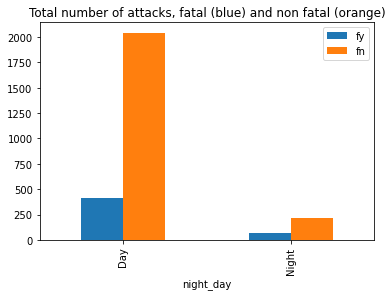

In [18]:
print('-Day counts:\n',data.loc[data.night_day=='Day','fatal'].value_counts())
print('-Night counts:\n',data.loc[data.night_day=='Night','fatal'].value_counts())


data.groupby(['night_day']).agg({'fy':'sum',
                                'fn':'sum'}).plot.bar(title='Total number of attacks, fatal (blue) and non fatal (orange)')
#I could have drawn the plot without creating the new two columns fy and fx and pivoting the table, 
# but this way I show another way to draw it...

However, these raw numbers are difficult to interpret. One way to meassure the severity of the attacks is checking for the percentage of fatal attacks. This is calculated by the custom function `fatality`. This way, we can answer the question: **are shark attacks more lethal during the night?**

In [21]:
#We use the custom function fatality to calculate % of fatal attacks.
overall_fatality = fn.fatality(data['fatal'])
print(f"The overall fatality is {round(overall_fatality,2)}%")

The overall fatality is 16.67%


Fatality:
 night_day
Day      15.965732
Night    22.327044
Name: fatal, dtype: float64


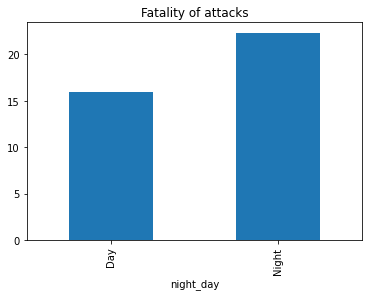

In [22]:
print('Fatality:\n', data.groupby(['night_day']).fatal.apply(fatality))
data.groupby(['night_day']).fatal.apply(fatality).plot.bar(title='Fatality of attacks')


This result supports my first hypothesis. Shark attacks are more lethal during the night. <br>What about the activities of the victims, **does it matter which activity the victim was practicing or whether it was practiced during the day or night?**

Total number of cases per activity and day night
   activity night_day  fatal
0   fishing       Day    368
1   fishing     Night     70
2     other       Day    192
3     other     Night     52
4  standing       Day    212
5  standing     Night     12
6   surfing       Day   1007
7   surfing     Night    102
8  swimming       Day    789
9  swimming     Night     82


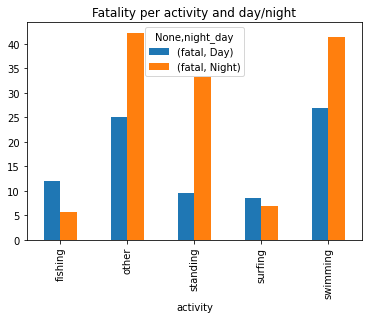

In [23]:
print('Total number of cases per activity and day night')
print(data[['activity','night_day','fatal']].groupby(['activity','night_day']).fatal.agg(len).reset_index())

data.pivot_table(values=['fatal'], index=['activity'], columns=['night_day'], aggfunc=fatality).plot.bar(title='Fatality per activity and day/night')

It seems that still, attacks are more lethal during the night, except for fishing and surfing. One possible explanation is that sharks stay during the night (and early hours) close to the breaks, where food is more available. Surfing and fishing may usually happen a bit more offshore.

What about time? **Has the lethality of attacks changed over the year?**<br>Let's take a look at the raw numbers per decade.

In [24]:
data[['decade','fatal', 'night_day']].groupby(['decade','night_day']).agg('count').sort_values(by='fatal', ascending = False).reset_index()

,decade,night_day,fatal
0,2000,Day,631
1,2010,Day,590
2,1950bef,Day,398
3,1990,Day,308
4,1960,Day,234
5,1980,Day,185
6,1970,Day,106
7,1950bef,Night,82
8,2000,Night,68
9,2010,Night,50


Again, there are considerable less observations during the night. Let's look at the overall fatality:

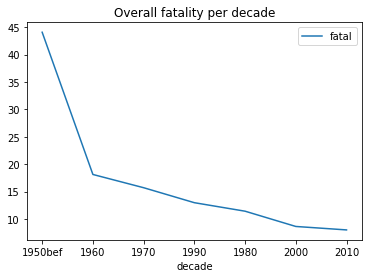

In [24]:
data[['decade','fatal']].groupby(['decade']).agg(fatality).sort_values(by='fatal', ascending = False).reset_index().plot('decade', 'fatal', title='Overall fatality per decade')

There is a clear descending pattern. This might be deceiving, as it is likely that in old times mostly those remarkably fatal attacks where recorded somehow.<br><br>Does the fatality changes during day and night over the decades?

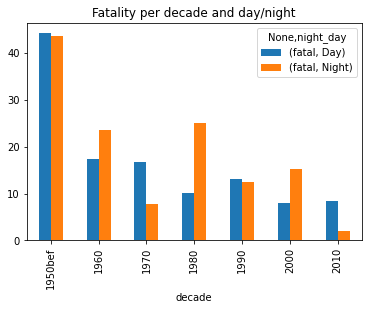

In [27]:
data.pivot_table(values=['fatal'], index=['decade'], columns=['night_day'], aggfunc=fatality).plot.bar(title='Fatality per decade and day/night')

In general, it seems that fatality is higher during the night, but there are some interesting things here, like the shift from the 2000's to the 2010's. Let's look closer into the 2010's and see what happened:

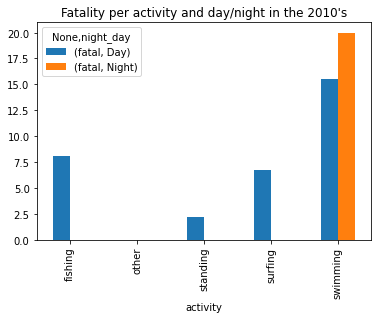

In [26]:
data[data.decade == '2010'].pivot_table(values=['fatal'], index=['activity'], columns=['night_day'], aggfunc=fatality).plot.bar(title="Fatality per activity and day/night in the 2010's")

Interesting, all the fatal attacks during the night happened while swimming. 

**In conclussion**, shark attacks in general are more lethal during the night, specially if the victim is performing an activity close to the shoreline. Although fatality seems to decrease over the decades, this could be an artifact of the data (more, less biased and more accurate records nowadays).<br>However, these conclussions have to be treated carefuly, since they are only based on a portion of the data (where time was somehow accurately reported).

## BONUS. How many deads by shark per country?

In [29]:
data_country = pd.read_csv('data_country.csv')

In [44]:
data_country['n_fatal'] = data_country['fatal'].apply(lambda x: 1 if x=='Y' else 0)
data_country[['fatal','n_fatal']]

,fatal,n_fatal
0,N,0
1,N,0
2,N,0
3,N,0
4,N,0
...,...,...
5804,Y,1
5805,Y,1
5806,Y,1
5807,Y,1


In [53]:
dta = data_country[['country', 'population','n_fatal']].groupby('country').agg({'population':'first','n_fatal':'sum'}).reset_index()
dta = pd.DataFrame(dta).set_index('country')
dta['per_mill'] = (dta.n_fatal/dta.population)*1000000
dta

,population,n_fatal,per_mill
country,,,
algeria,38700000.0,1,0.025840
american samoa,55519.0,3,54.035555
angola,24383301.0,0,0.000000
argentina,42669500.0,0,0.000000
aruba,101484.0,1,9.853770
...,...,...,...
uruguay,3404189.0,2,0.587511
vanuatu,264652.0,9,34.006922
venezuela,30206307.0,4,0.132423


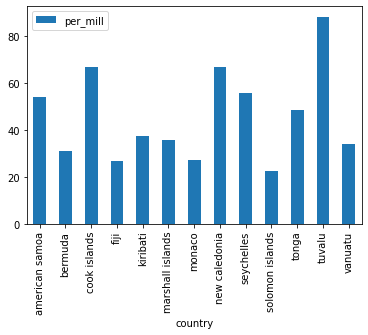

In [55]:
dta[['per_mill']][dta.per_mill>20].plot.bar()

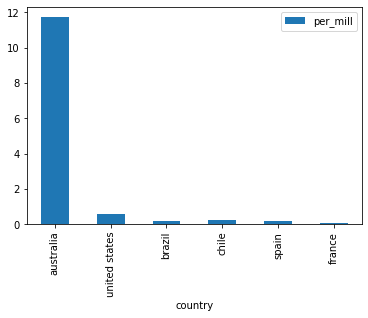

In [80]:
dta.loc[['australia','united states', 'brazil', 'chile','spain','france'],][['per_mill']].plot.bar()